In [124]:
import pandas as pd
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

In [5]:
spark = SparkSession.builder.getOrCreate()

In [74]:
df = pd.read_csv('data.csv', index_col=0)
df.drop(['Name', 'Type 1', 'Type 2', 'Generation', 'id', 'wins', 'total'], axis=1, inplace=True)
df.rename({'Sp. Atk': 'SpAtk', 'Sp. Def': 'SpDef'}, axis='columns', inplace=True)
columns = df.columns

In [75]:
df = spark.createDataFrame(df)
df

DataFrame[HP: bigint, Attack: bigint, Defense: bigint, SpAtk: bigint, SpDef: bigint, Speed: bigint, Legendary: boolean, %: double]

In [76]:
df.printSchema()

root
 |-- HP: long (nullable = true)
 |-- Attack: long (nullable = true)
 |-- Defense: long (nullable = true)
 |-- SpAtk: long (nullable = true)
 |-- SpDef: long (nullable = true)
 |-- Speed: long (nullable = true)
 |-- Legendary: boolean (nullable = true)
 |-- %: double (nullable = true)



In [77]:
df.take(1)

[Row(HP=45, Attack=49, Defense=49, SpAtk=65, SpDef=65, Speed=45, Legendary=False, %=0.2781954887218045)]

In [78]:
df.show()

+---+------+-------+-----+-----+-----+---------+-------------------+
| HP|Attack|Defense|SpAtk|SpDef|Speed|Legendary|                  %|
+---+------+-------+-----+-----+-----+---------+-------------------+
| 45|    49|     49|   65|   65|   45|    false| 0.2781954887218045|
| 60|    62|     63|   80|   80|   60|    false| 0.3801652892561984|
| 80|    82|     83|  100|  100|   80|    false| 0.6742424242424242|
| 80|   100|    123|  122|  120|   80|    false|               0.56|
| 39|    52|     43|   60|   50|   65|    false| 0.4910714285714286|
| 58|    64|     58|   80|   65|   80|    false| 0.5423728813559322|
| 78|    84|     78|  109|   85|  100|    false| 0.8646616541353384|
| 78|   130|    111|  130|   85|  100|    false| 0.8561151079136691|
| 78|   104|     78|  159|  115|  100|    false| 0.8444444444444444|
| 44|    48|     65|   50|   64|   43|    false| 0.1623931623931624|
| 59|    63|     80|   65|   80|   58|    false| 0.4184397163120567|
| 79|   103|    120|  135|  115|  

In [79]:
features = df.drop('%')
assembler = VectorAssembler(inputCols=features.columns, outputCol='features')
output = assembler.transform(df).select('features', '%')

In [80]:
train, test = output.randomSplit([0.75, 0.25])
train.show()

+--------------------+-------------------+
|            features|                  %|
+--------------------+-------------------+
|[10.0,55.0,25.0,3...| 0.5396825396825397|
|[25.0,20.0,15.0,1...| 0.3240740740740741|
|[30.0,56.0,35.0,2...| 0.4814814814814815|
|[35.0,55.0,40.0,5...| 0.6838235294117647|
|[35.0,60.0,44.0,4...|0.36641221374045796|
|[35.0,70.0,55.0,4...|0.09420289855072464|
|[35.0,80.0,50.0,5...|            0.84375|
|[38.0,41.0,40.0,5...| 0.4108527131782946|
|[40.0,35.0,30.0,2...|0.23423423423423426|
|[40.0,45.0,35.0,3...| 0.3793103448275862|
|[40.0,45.0,35.0,4...|               0.65|
|[40.0,45.0,40.0,3...|0.37301587301587297|
|[40.0,60.0,30.0,3...| 0.4492753623188406|
|[40.0,80.0,35.0,3...| 0.4661016949152542|
|[45.0,25.0,50.0,2...|0.13076923076923078|
|[45.0,49.0,49.0,6...| 0.2781954887218045|
|[45.0,50.0,55.0,7...|0.06293706293706294|
|[46.0,57.0,40.0,4...|               0.25|
|[50.0,20.0,55.0,2...|0.09774436090225563|
|[55.0,70.0,45.0,7...|               0.45|
+----------

In [101]:
errors = []
for i in range(1, 15):
    dt = DecisionTreeRegressor(featuresCol='features', labelCol = '%', maxDepth=i, seed=42)
    dt_model = dt.fit(train)
    predictions = dt_model.transform(test)
    pred_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='%', metricName='mse')
    errors.append(pred_evaluator.evaluate(predictions))

In [103]:
errors

[0.02127524749534784,
 0.007918825250314262,
 0.005902881375864716,
 0.004025868390037824,
 0.0034801764133801714,
 0.0034199657411386297,
 0.003892560229288274,
 0.004378269680163388,
 0.005001288957699821,
 0.005132168023402533,
 0.005250916386273367,
 0.005255924778449901,
 0.005283003799409523,
 0.005312532117160338]

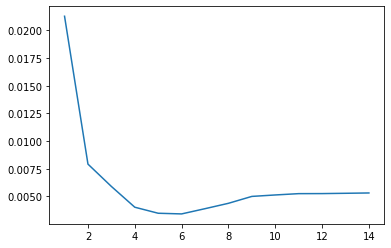

In [105]:
plt.plot(range(1, 15), errors)

In [107]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol = '%', maxDepth=6, seed=42)
dt_model = dt.fit(train)
predictions = dt_model.transform(test)

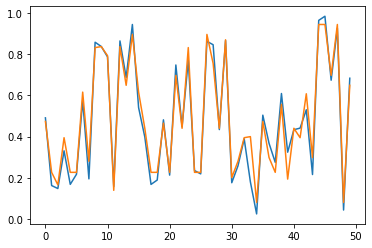

In [121]:
plt.plot(range(50), predictions.toPandas()['%'][:50])
plt.plot(range(50), predictions.toPandas()['prediction'][:50])

In [122]:
pred_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='%', metricName='mse')
pred_evaluator.evaluate(predictions)

0.0034199657411386297

In [123]:
pred_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='%', metricName='r2')
pred_evaluator.evaluate(predictions)

0.9489017043773322

In [125]:
rf = RandomForestRegressor(featuresCol='features', labelCol = '%', seed=42)
rf_model = rf.fit(train)
predictions = rf_model.transform(test)

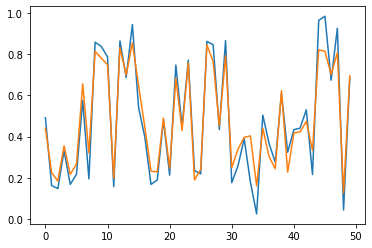

In [126]:
plt.plot(range(50), predictions.toPandas()['%'][:50])
plt.plot(range(50), predictions.toPandas()['prediction'][:50])

In [128]:
pred_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='%', metricName='mse')
pred_evaluator.evaluate(predictions)

0.004785020882782255

In [129]:
pred_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='%', metricName='r2')
pred_evaluator.evaluate(predictions)

0.9285061810158247

In [130]:
reg = LinearRegression(featuresCol='features', labelCol='%')
lm = reg.fit(train)
predictions = lm.transform(test)

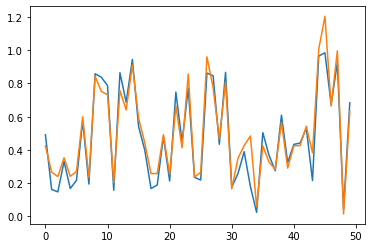

In [131]:
plt.plot(range(50), predictions.toPandas()['%'][:50])
plt.plot(range(50), predictions.toPandas()['prediction'][:50])

In [132]:
pred_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='%', metricName='mse')
pred_evaluator.evaluate(predictions)

0.004934478887560388

In [133]:
pred_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='%', metricName='r2')
pred_evaluator.evaluate(predictions)

0.9262731032924248